Installing tfds (tensorflow dataset) :

In [1]:
!pip install -q tfds-nightly
!tfds --version

     |████████████████████████████████| 3.7MB 15.8MB/s 
2020-12-11 12:22:56.695556: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
TensorFlow Datasets: 4.1.0+nightly


Clone the source repo from GitHub

In [120]:
!git clone "https://github.com/heolfief/Where_is_Waldo_AI_solver.git"

fatal: destination path 'Where_is_Waldo_AI_solver' already exists and is not an empty directory.


Create the images for the dataset

In [117]:
!python Where_is_Waldo_AI_solver/scripts/image_cutter.py

Warning, the following process may be quite long
100% 18/18 [00:13<00:00,  1.38it/s]


Building the dataset from the python script:

In [118]:
!tfds build Where_is_Waldo_AI_solver/scripts/create_TFDS.py --overwrite

2020-12-11 13:31:24.219337: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1211 13:31:26.145683 140320831289216 dataset_info.py:366] Load dataset info from /root/tensorflow_datasets/waldo_dataset/1.0.0
2020-12-11 13:31:26.150880: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2020-12-11 13:31:26.212967: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
I1211 13:31:26.250997 140320831289216 build.py:345] download_and_prepare for dataset waldo_dataset/1.0.0...
I1211 13:31:26.252944 140320831289216 dataset_builder.py:393] Generating dataset waldo_dataset (/root/tensorflow_datasets/waldo_dataset/1.0.0)
2020-12-11 13:31:26.314811: I tensorflow/core/platform/cloud/google_auth_pr

Testing the dataset :

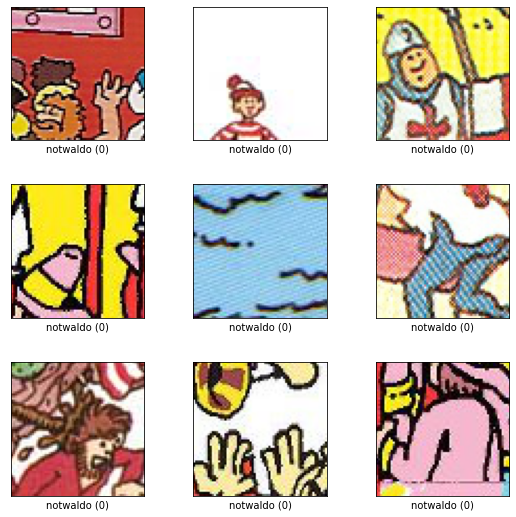

tfds.core.DatasetInfo(
    name='waldo_dataset',
    version=1.0.0,
    description='Where is Waldo dataset',
    homepage='https://github.com/heolfief/Where_is_Waldo_AI_solver',
    features=FeaturesDict({
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7852,
    splits={
        'train': 7852,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



In [121]:
import tensorflow_datasets as tfds
ds, ds_info = tfds.load('waldo_dataset', split='train', with_info=True,  shuffle_files=True, as_supervised=True)
fig = tfds.show_examples(ds, ds_info)
print(ds_info)


In [122]:
# Recover the size of the whole dataset
ds_size = ds.cardinality().numpy()
# Define sizes for train and test sets
train_size = int(0.7 * ds_size)
val_size = int(0.15 * ds_size)
test_size = int(0.15 * ds_size)

# Define train and test sets according to sizes
train_dataset = ds.take(train_size)
temp = ds.skip(train_size)

test_dataset = temp.take(test_size)
val_dataset = temp.skip(test_size)

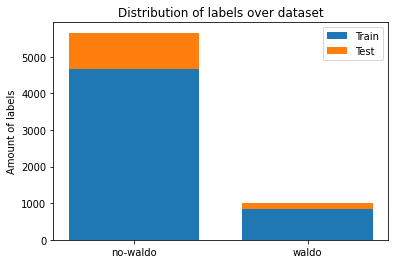

In [123]:
import collections
import numpy as np
import matplotlib.pyplot as plt

# Recover distribution of classes among datasets
def get_class_distribution(dataset):
    class_distribution = {}
    for element in dataset.as_numpy_iterator():
        label = element[1]

        if label in class_distribution.keys():
            class_distribution[label] += 1
        else:
            class_distribution[label] = 0

    # sort dict by key
    class_distribution = collections.OrderedDict(sorted(class_distribution.items())) 
    return class_distribution

train_distribution = get_class_distribution(train_dataset)
test_distribution = get_class_distribution(test_dataset)

# Plot distribution
indices = np.arange(len(train_distribution))
width = 0.75
train_plot = []
test_plot = []
for label, amount in train_distribution.items():
  train_plot.append(amount)
for label, amount in test_distribution.items():
  test_plot.append(amount)

p1 = plt.bar(indices, train_plot, width)
p2 = plt.bar(indices, test_plot, width, bottom=train_plot)
plt.ylabel('Amount of labels')
plt.title('Distribution of labels over dataset')
plt.xticks(indices, ('no-waldo', 'waldo'))
l = plt.legend((p1[0], p2[0]), ('Train', 'Test'))
plt.show()

**Build CNN :**

In the menu "Execution" -> modify execution type and select GPU. Once execution type is correctly configured, the GPU model should appaers below 

In [124]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7922213158683349544, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9508474264682052731
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17786892003501335904
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16239676644046180553
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

Load dataset in a dataset class :

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,experimental
import time

train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(128)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(128)
#val_dataset = val_dataset.shuffle(1000)
val_dataset = val_dataset.batch(128)

In [126]:
CNN = Sequential()

data_augmentation = keras.Sequential(
  [
    experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 3)),
    experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(64, 
                                                              64,
                                                              3)),
    experimental.preprocessing.RandomContrast(0.4)
  ]
)

CNN.add(data_augmentation)
CNN.add(Conv2D(64, (2, 2), input_shape=(64, 64, 3),
                      padding='valid',
                      name='Convolution-1',
                      activation='relu'))
CNN.add(Conv2D(64, (2, 2), padding='valid',
                      name='Convolution-2',
                      activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2),
                            name='Pooling-1'))
CNN.add(Dropout(0.05))

CNN.add(Conv2D(128, (2, 2), padding='valid',
                      name='Convolution-3',
                      activation='relu'))
CNN.add(Conv2D(128, (2, 2), padding='valid',
                      name='Convolution-4',
                      activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2),
                            name='Pooling-2'))
CNN.add(Dropout(0.10))

CNN.add(Conv2D(256, (2, 2), padding='valid',
                      name='Convolution-5',
                      activation='relu'))
CNN.add(Conv2D(256, (2, 2), padding='valid',
                      name='Convolution-6',
                      activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2),
                            name='Pooling-3'))
CNN.add(Dropout(0.1))

CNN.add(Flatten())
CNN.add(Dense(512,
                     name='Dense-1',
                     activation='relu'))
CNN.add(Dropout(0.1))
CNN.add(Dense(2,
                     name='Dense-2',
                     activation='softmax'))



CNN.compile(  loss=tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, 
    reduction="auto", 
    name="sparse_categorical_crossentropy"
    ),
    optimizer='adam',
    metrics=['accuracy']
    )

class_weight = {0: 1,
                1: train_plot[0]/train_plot[1]}

history = CNN.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weight)


Epoch 1/20
43/43 [==============================] - 6s 135ms/step - loss: 1.1658 - accuracy: 0.4893 - val_loss: 0.6202 - val_accuracy: 0.8422
Epoch 2/20
43/43 [==============================] - 3s 73ms/step - loss: 0.9362 - accuracy: 0.6900 - val_loss: 0.3983 - val_accuracy: 0.7701
Epoch 3/20
43/43 [==============================] - 3s 74ms/step - loss: 0.8101 - accuracy: 0.6903 - val_loss: 0.4836 - val_accuracy: 0.6870
Epoch 4/20
43/43 [==============================] - 3s 74ms/step - loss: 0.7347 - accuracy: 0.7558 - val_loss: 0.2520 - val_accuracy: 0.8609
Epoch 5/20
43/43 [==============================] - 3s 74ms/step - loss: 0.6282 - accuracy: 0.7969 - val_loss: 0.2242 - val_accuracy: 0.8838
Epoch 6/20
43/43 [==============================] - 3s 73ms/step - loss: 0.5788 - accuracy: 0.7997 - val_loss: 0.2050 - val_accuracy: 0.9033
Epoch 7/20
43/43 [==============================] - 3s 73ms/step - loss: 0.4747 - accuracy: 0.8623 - val_loss: 0.1720 - val_accuracy: 0.9262
Epoch 8/20
4

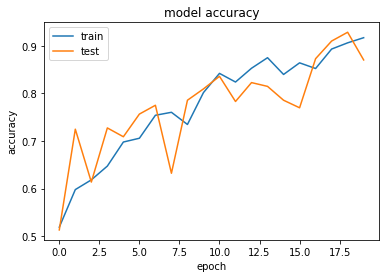

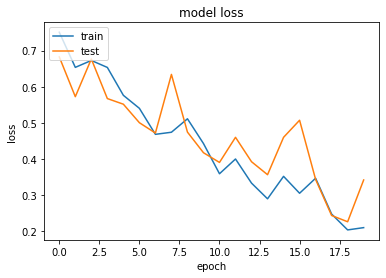

In [110]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

10/10 [==============================] - 0s 26ms/step - loss: 0.0077 - accuracy: 0.9966
[0.00774003379046917, 0.9966015219688416]
1179
1179
[[988   5]
 [  0 186]]


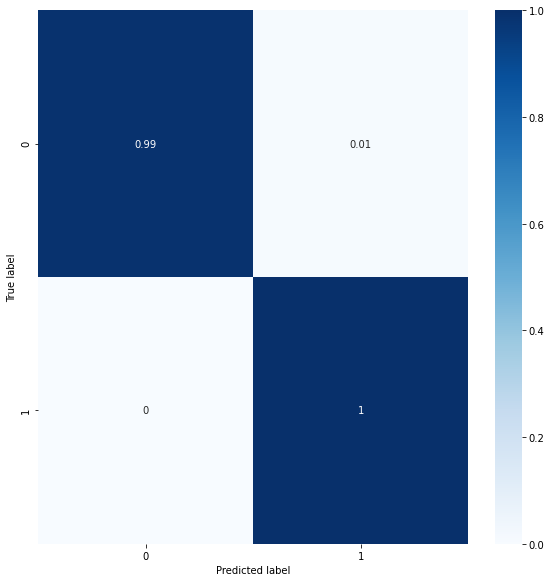

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

accuracy=CNN.evaluate(test_dataset)
print(accuracy)


y_pred=CNN.predict_classes(val_dataset)
print(y_pred.size)
true_categories = tf.concat([y for x, y in val_dataset], axis=0)
print(true_categories.numpy().size)
con_mat = tf.math.confusion_matrix(labels=true_categories, predictions=y_pred).numpy()
print(con_mat)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes = [0, 1]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
